# Project Notebook Introduction

Welcome to the main project notebook! 

## What is the goal of this notebook?

This notebook should contain your project write-up and the analyses conducted on the provided data. For each project, the notebook provides links to a few articles on the subject of the notebook, and a few examples of analyses that you could/should do. But it is not at all exhaustive: If you need to install more python packages or other software, do so. If you want to search for additional literature to support your writing, do so!

Your goal is to work from these examples towards answering the list of questions specific to each of the projects, and write a coherent report following the structure at the bottom of this notebook. Your colleagues (and I) will read and grade the result. So, make sure that you provide ample and adequate descriptions of your results and methodologies. This notebook is likely going to get rather large as you add analyses, so best to use markdown cells and headings to create a table of contents structure, as you can see in the ToC menu on the left of the Colab user interface.  

If this project feels a bit open-ended, that's because it is - just like actual research! ***But you are not alone!*** You will collaborate with your fellow students in your group! I also want to push you towards asking any and all questions in the canvas discussions, and directly to me via email and the Friday Zoom meetings. I'm here to help, and will give hints if you ask me the right questions. 

You are free to make this as beautiful and far-reaching as you feel like. But keep track of time, you will need to finish this the week before the exam. Perfect is the enemy of good, beware. 


## Installation etc.

The first part of this notebook is shared across the different projects, as the notebook will download the data for all the projects in the same way. 

The first installation and setup cells may take a little while to run as they fetch and install all the required software. It's also likely there's going to be a LOT of outputs that are irrelevant. Feel free to delete the output of this cell after it runs to free up space. 

In [2]:
# this cell installs some dependencies. 
# feel free to disregard the output this generates

!apt -qq install inkscape > /dev/null
!pip -qq install nibabel nilearn
!pip -qq install git+https://github.com/gallantlab/pycortex.git#egg=pycortex



Extracting templates from packages: 100%
     |████████████████████████████████| 10.1 MB 6.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
# after these basic installs, we can import our required packages. 

import numpy as np
import scipy as sp
import nibabel as nb
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request

from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
%matplotlib inline 

### Download of data: surfaces for plotting and project data

Both the surface data we'll use for visualization and the project fMRI data are on figshare. From Figshare, we can download the data and place them in the Colab virtual machine. You don't have to read/understand this code - it's all boilerplate stuff to set up Colab's virtual machine so that it works with our data. 

***More important:*** For a brief description of the data of the different projects, --and a couple of very important parameters of these acquisitions which you will need later-- please consult the [figshare website](https://figshare.com/articles/dataset/fMRI_Teaching_Materials/14096209)

In [4]:
#
# this cell ensures that we can work with our own surface from within the colab environment
#

os.makedirs('/content/pycortex/db', exist_ok=True)
os.makedirs('/content/pycortex/colormaps', exist_ok=True)
os.makedirs('/content/data', exist_ok=True)

wrong_filestore_location = 'build/bdist.linux-x86_64/wheel/pycortex-1.3.0.dev0.data/data/share/pycortex/'
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'r') as f:
  file_source = f.read()
replace_string = file_source.replace(wrong_filestore_location, '/content/pycortex/') #save output 
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'w') as f:
  f.write(replace_string)   

os.chdir('/tmp/')
!git clone https://github.com/gallantlab/pycortex.git
!cp /tmp/pycortex/filestore/colormaps/* /content/pycortex/colormaps/

#
# and we'll download our average hcp subject for pycortex visualization
#

pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

urllib.request.urlretrieve(pycortex_sj_URL, os.path.join('/content/pycortex/db', 'hcp_999999.zip'))
!unzip -qq /content/pycortex/db/hcp_999999.zip -d /content/pycortex/db/

#
# and then download the projects' data from figshare
#

timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
urllib.request.urlretrieve(timeseries_data_URL, os.path.join('/content/data', '14096209.zip'))
!unzip -qq /content/data/14096209.zip -d /content/data/
!unzip -qq /content/data/hrf_mapper_59k.zip -d /content/data/hrf_mapper_59k/
!unzip -qq /content/data/prf_mapper_59k.zip -d /content/data/prf_mapper_59k/
!unzip -qq /content/data/soma_mapper_59k.zip -d /content/data/soma_mapper_59k/
!unzip -qq /content/data/atlas.zip -d /content/data/

Cloning into 'pycortex'...
remote: Enumerating objects: 23881, done.
remote: Counting objects: 100% (2285/2285), done.
remote: Compressing objects: 100% (776/776), done.
remote: Total 23881 (delta 1530), reused 2155 (delta 1450), pack-reused 21596
Receiving objects: 100% (23881/23881), 476.15 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (18212/18212), done.


## Putting these tools to first use

Ok, why all this complicated hassle? Well, we want you to have a playground that allows you to really get to know the data. 

#### Where are the data files?

The data have now been downloaded, and you can check out the data on disk by using the command line. For example, in a code cell you can preface the line with an exclamation mark to give a commandline command: 

`!ls /content/data/prf_mapper_59k`

Will give you the contents of the prf experiment data folder. But, on the left in the CoLab UI you can also find a file navigator, next to the table of contents, search and code snippet elements. Feel free to have a look around!

#### Okay, but what can we do with these tools?

After downloading and auto-editing the data required for working with pycortex, we can now import pycortex. We'll use pycortex for plotting of the results, which is using only a subset of its awesome features. Remember that [brain viewer of semantic maps](http://gallantlab.org/huth2016/)? Also made using pycortex! If you have some spare time and want to play around with this awesome package, please have a look at the [pycortex docs](https://gallantlab.github.io/pycortex/)

In [5]:
import cortex as cx

And, just to highlight the type of visualisation we'll be doing, a quick demo of the way we'll be using it. We'll be using the surface from the Human Connectome Project, which we named `hcp_999999`. So that's the 'subject' name we use to get and plot surface data using pycortex. 

Don't worry if you see a bunch of warnings and stuff - it will create the figure we asked for from what is in essence a single line of code: the curvature of the cortical surface of this standard surface. **Gorgeous!** 

Feel free to change the datatype to `'thickness'`, for example. Also **Gorgeous!**

Generating a flatmap cache
Failed to get connection
** (inkscape:3354): CRITICAL **: 14:44:13.431: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3354): CRITICAL **: 14:44:13.431: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3354): CRITICAL **: 14:44:13.431: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


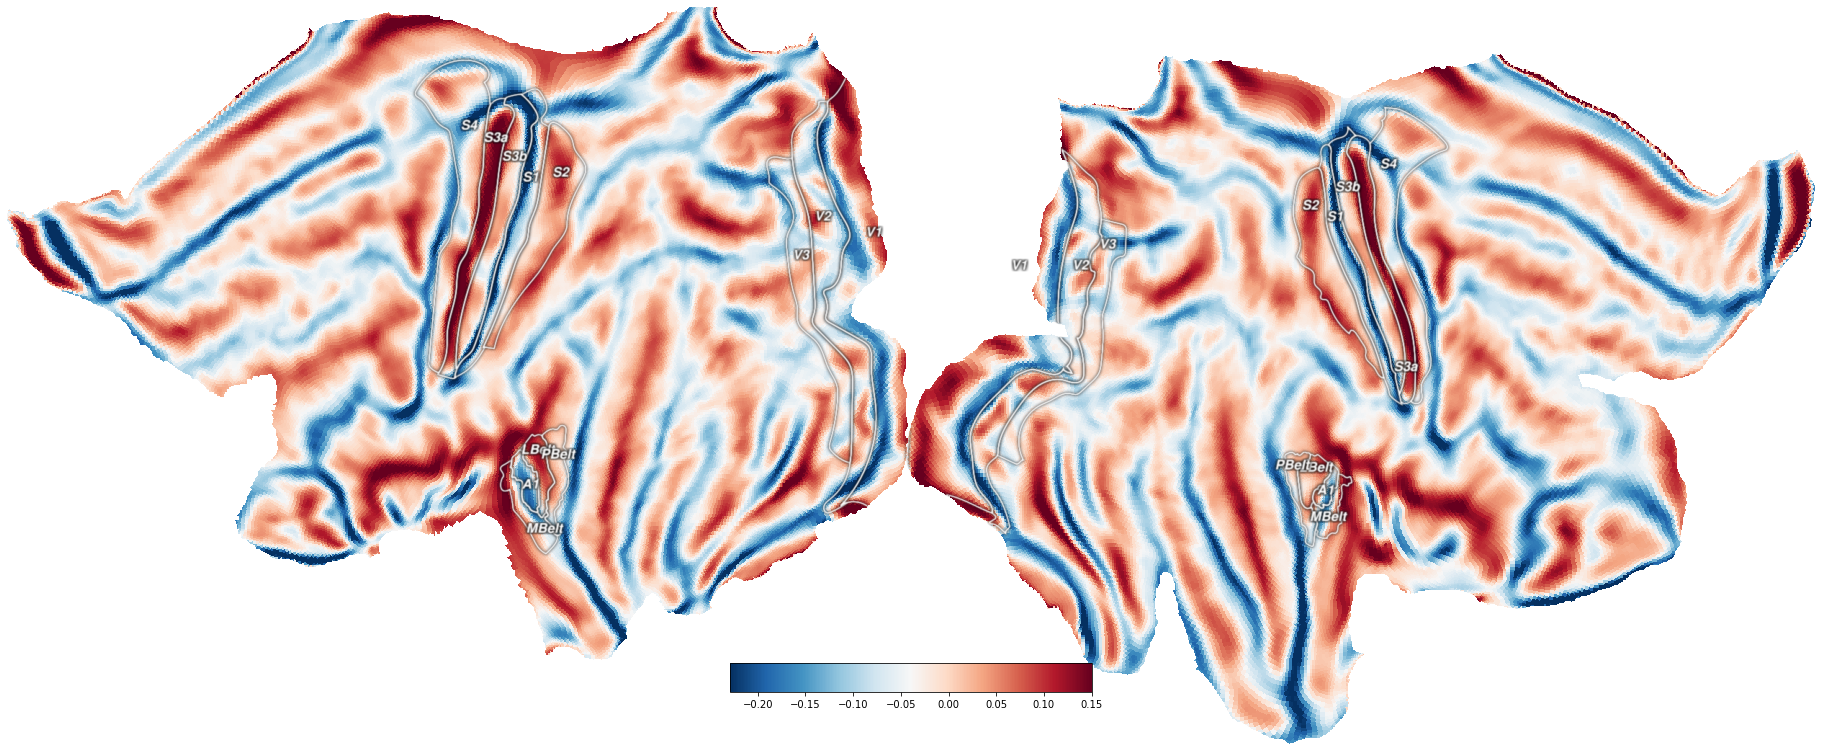

In [6]:
curv_vertices = cx.db.get_surfinfo(subject='hcp_999999', type='curvature')
cx.quickshow(curv_vertices);

### Flatmaps?

But what the hell are we looking at, even? The cortical surface or ribbon is topologically a ball per hemisphere. That is, each hemisphere can be inflated to the shape of a sphere (let's not get stuck on the question how a hemisphere can also be a sphere :-) ). Flatmaps are created by cutting the inflated cortical surface at specific locations (see the black lines in the left figure), and then letting the computer flatten the resulting mesh into a planar surface. 

<img src="https://github.com/VU-Cog-Sci/wiki/raw/master/imgs/flatten/image9.png" alt="where do we cut the surface" width="45%" style="align:left;"/> <img src="https://universe-review.ca/I10-13-BrainMap3.jpg" alt="Visual, auditory and somatosensory brain regions" width="45%" style="align:right;"/>

This flatmapping has the advantage that we can view the entire cerebral cortex in one fell swoop, but the downside is that it is hard to orient yourself to where things are. That's why we've added some lines that surround certain labeled regions of interest - they are the visual, auditory and somatosensory/motor cortex. In the right image they are the blue, red and green areas of the brain, respectively. We're using exactly the flattened surfaces of the right column in the right figure, but ours are rendered side-by-side. Recognize them from the curvature figure?

Take a few minutes to orient yourself on these surfaces, using the atlas in the right figure. Where are the darker areas of this atlas on the inflated surfaces, and where do they end up on the flattened surface? Same for the coloured regions - make sure you have an idea of where things are. This will greatly increase your maneuverability in the brain. 

You'll need that maneuverability because we'll be working with surface data in this project: all the data you will load is surface-based, and should be visualized as shown in this introduction. In many ways, surface-based fMRI data is simpler than volume-based data. Instead of 4-dimensional, it's 2-dimensional: vertices by timepoints. This makes it less of a bookkeeping hassle to use. Let's have a look at some of your fMRI time-course data!


## Loading the functional data for your project

In the cell below we're loading the functional MRI files you'll be working with. There's a different set of files that you open and read depending on the project that you'll be doing. Once loaded, though, all of these datasets have the same format - they're all formatted for the same surface that you've already plotted data into. 

In [7]:
# Here, I'm using python's awesome f-string functionality to load the data in a structured way across hemisperes. 
# Once the data have been loaded (for plotting and stuff), we don't have to care about hemispheres so much anymore. 
# There are 3 separate versions here, one for each project-dataset.


#########################################################################################################
###############
############### pRF mapping data
###############
#########################################################################################################

# tseries_raw = np.nan_to_num(np.concatenate([load_surf_data(
#         os.path.join('/content/data/prf_mapper_59k', f'sub-02_task-prf_space-59k_hemi-{hemi}_run-median_desc-bold.func.gii'))
#          for hemi in ['L', 'R']]))

#########################################################################################################
###############
############### somatotopic mapping data
###############
#########################################################################################################

tseries_raw = np.concatenate([load_surf_data(
        os.path.join('/content/data/soma_mapper_59k', f'sub-01_ses-01_task-soma_run-median_space-59k_hemi-{hemi}_sg_psc.dtseries.gii'))
         for hemi in ['L', 'R']])

#########################################################################################################
###############
############### hrf mapping data
###############
#########################################################################################################

# tseries_raw = np.concatenate([load_surf_data(
#         os.path.join('/content/data/hrf_mapper_59k', f'sub-012_ses-2_task-hrfmapper_run-1_bold_space-T1w_preproc_59k.{hemi}.dtseries.gii'))
#          for hemi in ['L', 'R']])


# and, we'll check the shape of the data to see whether things make sense
# data should be shaped as vertices by timepoints, and each hemisphere is 59k vertices - hence the name :) 
print(tseries_raw.shape)

(118584, 141)


## Raw Data Observations
### What amount of preprocessing has already been done?

If the signals have been filtered already, there should be no drifts in the data. Also, if the data time-courses have already been z-scored or converted to percent signal change, the mean of the signals should already be 0. If the data are in 'units' of % signal change, the maximal excursions of the signal timecourse will be on the order of 10-20. If they've been z-scored, their standard deviation should be exactly 1 (duh!). 

Like we learned in the preprocessing lecture and practical, the standard deviation over time also gives us a lot of valuable information regarding signal quality in non-z-scored data. Let's have a quick look at these different aspects of the data on flatmaps. This will also show us whether we were scanning the whole brain or not - an aspect of the data acquisition that you may want to mention in your report...

**Note**
If we plot data that didn't come from pycortex's surface data itself, but from our own files, we need to supply a subject. Adding the colormap is just for clarity. 

Failed to get connection
** (inkscape:3390): CRITICAL **: 14:46:51.945: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3390): CRITICAL **: 14:46:51.945: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3390): CRITICAL **: 14:46:51.945: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3393): CRITICAL **: 14:46:53.284: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3393): CRITICAL **: 14:46:53.284: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3393): CRITICAL **: 14:46:53.284: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


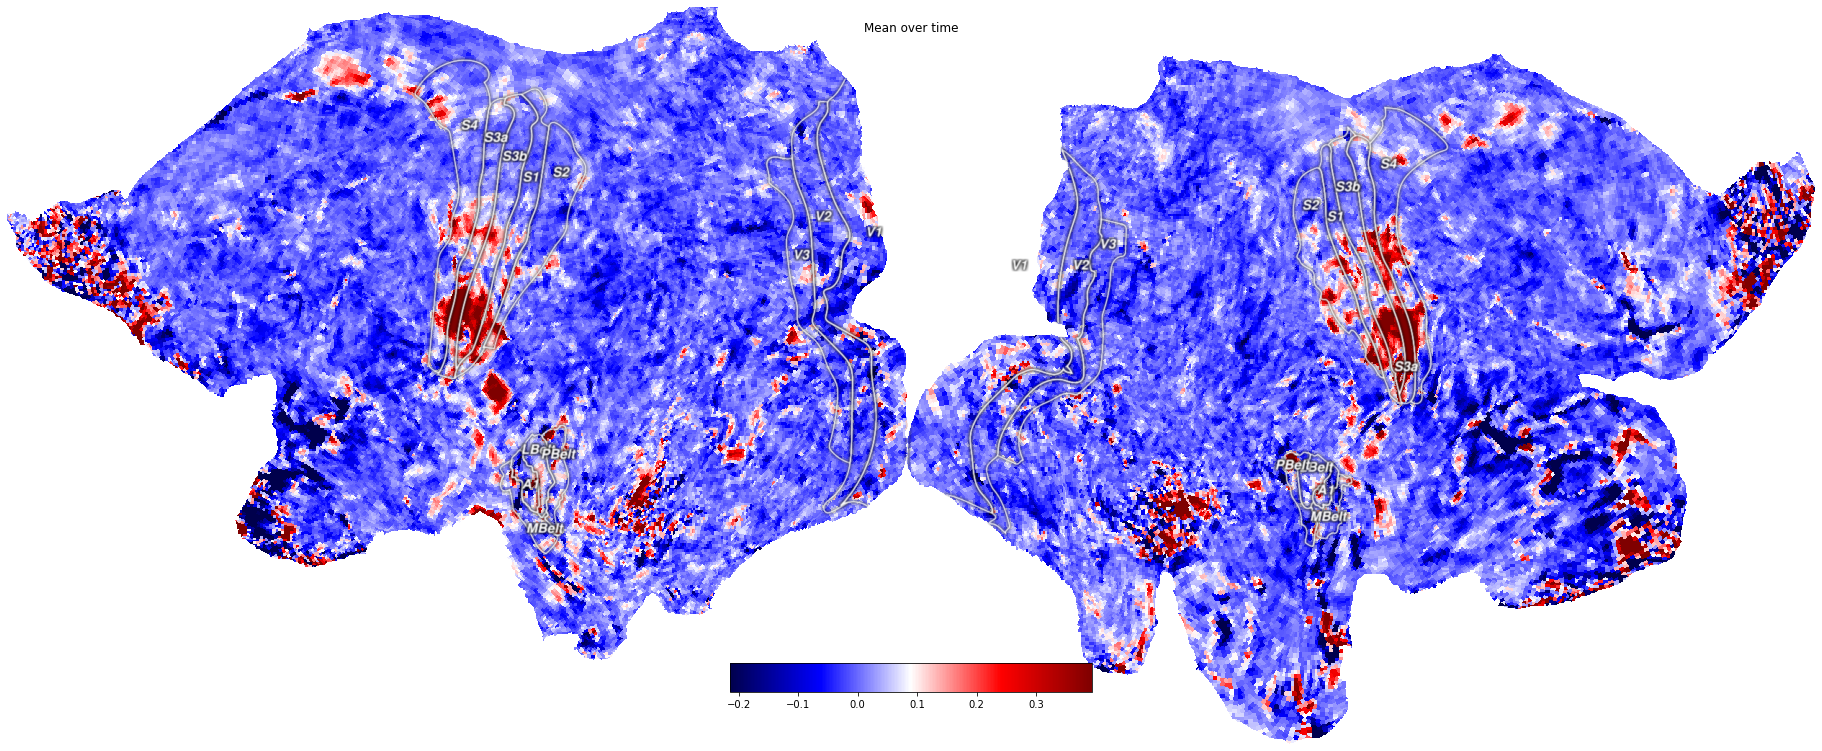

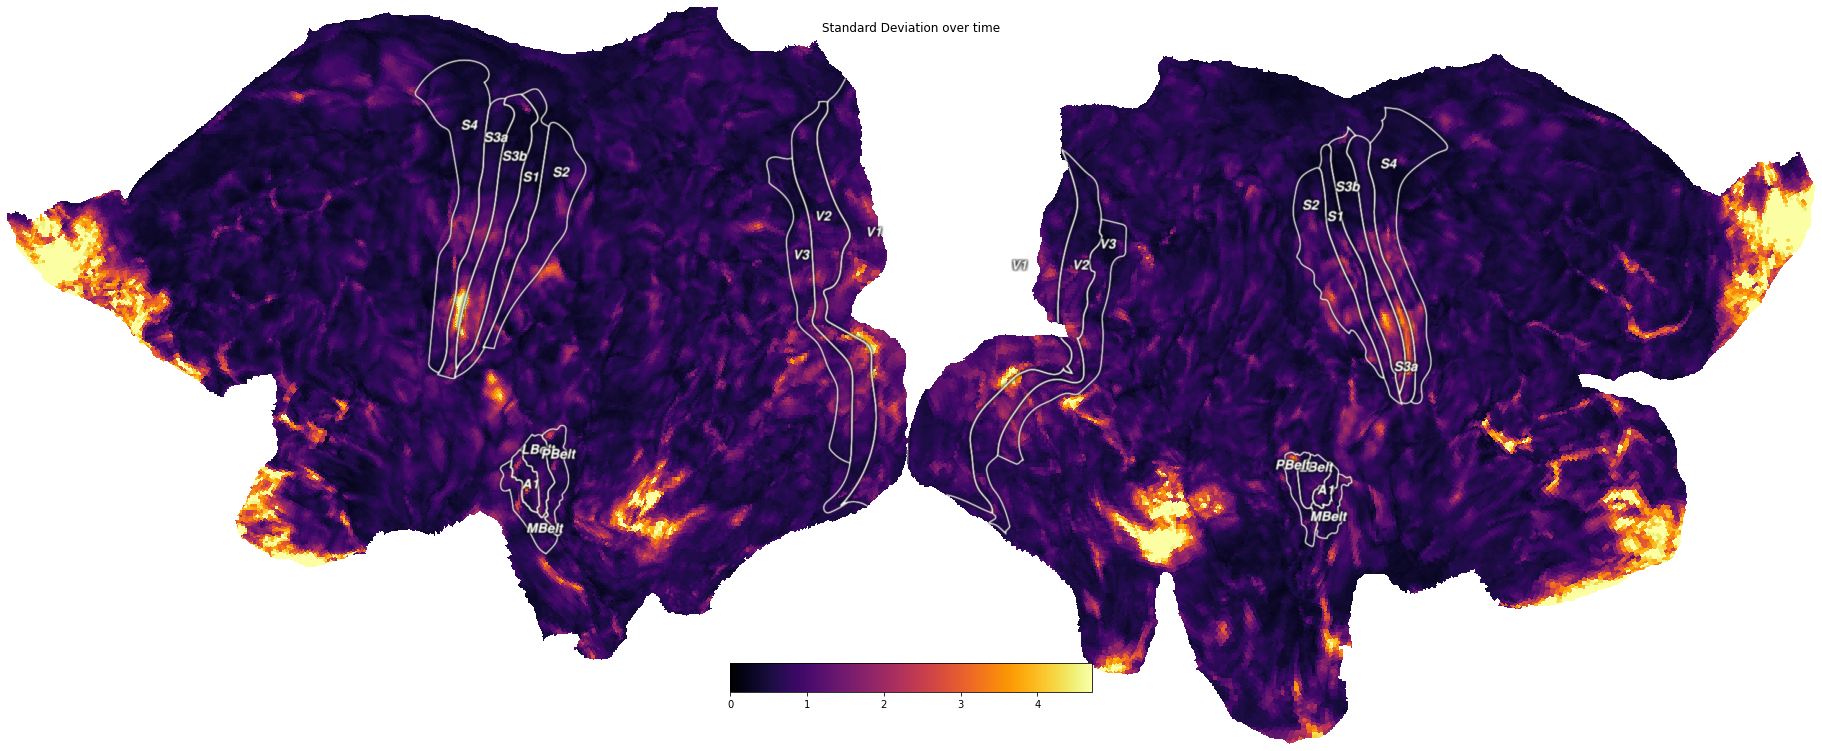

In [8]:
# Note that we saw in the cell above that the second dimension is time, 
# so the axis on which we take the mean and standard deviation is 1
f = cx.quickshow(cx.Vertex(tseries_raw.mean(axis=1), subject='hcp_999999', cmap='seismic'));
f.suptitle('Mean over time')

f = cx.quickshow(cx.Vertex(tseries_raw.std(axis=1), subject='hcp_999999', cmap='inferno'));
f.suptitle('Standard Deviation over time');

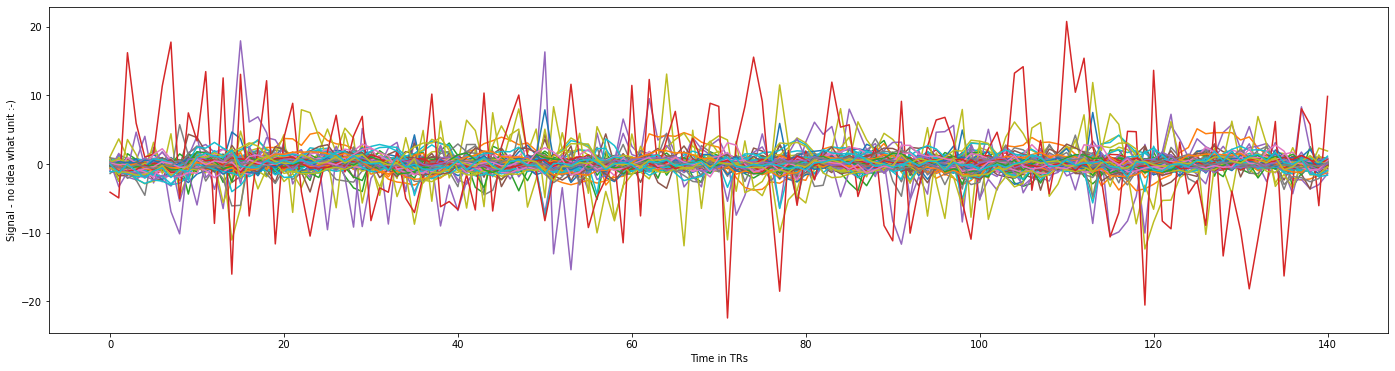

In [9]:
# now, let's get some random time-courses to check whether there's still drift:
random_vertices = np.random.choice(np.arange(tseries_raw.shape[0]), 100)
f = plt.figure(figsize=(24,6))
plt.plot(tseries_raw[random_vertices].T)
plt.xlabel('Time in TRs')
plt.ylabel('Signal - no idea what unit :-)');

Now, depending on your dataset you may see that the top of the brain is brighter than the bottom. This is due to the fact that the top of the brain is closer to the coils. Moreover, you may see some really interesting web-like pattern on the surfaces that you've plotted. Like this:

<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/lqPTAzK.png" alt="Model pipeline" width="500" align="right" />

What is that stuff? Why isn't it homogeneous? The answer is, we're looking at blood, and at 7 Tesla (at which all these data were acquired) these veins show up very strongly. Their presence has a strong influence on whether you can find any 'activation', as they may get in the way of what you want to find. Keep this in mind!

### Questions concerning signal quality

From these simple surface and time-course plots above, we can immediately gather a couple of things. Try to answer the following questions from both the flatmaps and the random time-courses. 

1.   have these data been z-scored or percent signal changed? **Check the colorbars!** What would they look like if they'd been z-scored?
2.   have these data been high-pass filtered? **Check the timecourses!**
3.   where do you see the biggest signal fluctuations? What are the likely origins of these fluctuations? 

You can use these insights in writing the data description section of your report! Note that there are differences between the different project-datasets, so make sure you inspect your own!

<font color='red'>-- Important: --</font>

**Your conclusions about the state of the data for your project will tell you what to do: you now have to decide whether to perform additional preprocessing, such as temporal filtering, percent signal change conversion, etc.**

## Atlas tools

It's a very powerful thing to be able to plot stuff on the entire cerebral cortex in one go. But sometimes you want to focus on a single brain region. You can use your own methods to define regions of interest, for example using a separate mapper experiment that allows you to select voxels/vertices of interest - within which you'll then perform your analysis of interest. 

But we'll use the existing multi-modal parcelation atlas from the Human Connectome Project, from the [Glasser et al Nature study](https://www.nature.com/articles/nature18933) that was mentioned a couple of times in the lectures. This is the atlas shown in the right flatmap figure above, in the 'Flatmaps' section.

The following cells show how to select a given ROI's data - something that you may want to do quite a lot in your own analyses. It serves to zoom into a specific region of interest, but also means that you can 'pilot' time-consuming analyses on smaller amounts of data while still taking care to test your entire analysis. 

In [ ]:
# we read in the atlas data, which consists of 180 separate regions per hemisphere. 
# These are labeled separately, so the labels go to 360. 
# To work with them in both hemispheres simultaneously, we mod by 180. 
atlas_data = np.concatenate([load_surf_data(
        os.path.join('/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

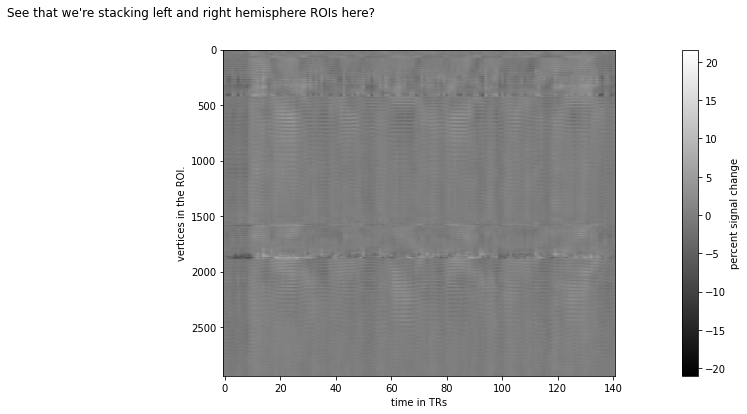

In [ ]:
roi_boolean_mask = atlas_data_both_hemis == 1

# but let's look at the actual signals after percent signal change conversion. 
def psc(data):
  """take percent signal change of data along axis 1. 
  This implementation is a bit idiosyncratic since 
  it uses the median instead of the mean of the signal.
  For sparse signals with very strong activations (such as those at 7T)
  this approach makes sense. Can you imagine why?"""
  # crudely checking whether psc hasn't already happened, in which case do nothing
  if np.mean(data) < 0.5:
    return data
  return ((data.T/np.median(data, 1)).T - 1) * 100

f = plt.figure(figsize=(24,6))
plt.imshow(psc(tseries_raw[roi_boolean_mask]), aspect=1/25, cmap='gray')
plt.xlabel('time in TRs')
plt.ylabel('vertices in the ROI.')
plt.colorbar(label='percent signal change')
f.suptitle("See that we're stacking left and right hemisphere ROIs here?");

To help you out a bit, here's a dictionary that gives you the indices in the atlas for the regions that are outlined in the flatmaps. This may help you find your way later on :-)

In [ ]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

**Units**

Because of the organization of the visual system, we'll now want to convert the parameters of the best-fitting model from x0 and y0 to eccentricity and polar angle, as you saw in the Dumoulin 2008 paper. The functions to do this are given below: 

In [ ]:
# But working with polar coordinates is a bit hairy.
# The easiest way to go is through complex numbers. 
# you don't need to understand the following completely, 
# but you can use the code. It will also take arrays for 
# x0 and y0.

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

To plot polar angle on the surface, you should use a circular colormap because phase is a circular measure. Please see the pycortex website for a collection of colormaps: https://gallantlab.github.io/pycortex/colormaps.htm

# Project 2: Soma-Mapper

This section will explain the experiment, background and analysis plans for the Soma-mapper dataset.  You should feel free to use any and all information in this "Project Explanation" section in your own report. Before going through this section, though, read the following relevant articles: [New Whole-Body Sensory-Motor Gradients Revealed Using Phase-Locked Analysis and Verified Using Multivoxel Pattern Analysis and Functional Connectivity, Zeharia et al, 2015](https://www.jneurosci.org/content/jneuro/35/7/2845.full.pdf), and [The ‘creatures’ of the human cortical somatosensory system, Saadon-Grosman et al, 2020](https://academic.oup.com/braincomms/article/2/1/fcaa003/5709029). If you have any questions about the type of experiment we're going to be looking at, and the different analysis steps, please ask me.

<img style="float:left; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/8P79rY0.png" alt="Model pipeline" width="500" align="left" />

## Somatotopic Mapper: the Experiment. 

This experiment was conducted by Ines, the course TA, for her PhD project. It's a motor mapper - and not a somatosensory mapper like in one of the original articles - that served to map out the subject's motor strip in the central sulcus. 

Subjects viewed a movie of an avatar that moved its facial muscles, hands and legs in a quasi-cyclic order that was identical across runs. On some cycles subjects moved both hands/legs, and on some they only moved one side. With a design like this we can investigate and chart not just the lateralized motor map, but also whether responses in for example the right-hand region are similar when we move the right hand, or both. You can see example timecourses from two voxels; one from the hand and one from the face. There are even [studies reporting pRF-like analyses](https://www.sciencedirect.com/science/article/pii/S105381191830569X) (see the pRF project if you want to know more) on experiments such as these. But for now, we won't be going there. 

The data that we will analyze here is the average across 5 runs for a single subject. We don't want to be "scraping the bottom of the barrel", so using this averaged data means that it is very high-signal data, and we can go into detail a bit. We will analyze these data using a 'standard' GLM, and will then inspect the sensitivities along the central sulcus. **Can we find the hand-, leg-, and face regions of the motor cortex? Let's find out!**



## Experimental Design

This experimental design is a blend between an event-related and a block design. We can find what happened when on the screen by inspecting what's in the `events.tsv` file. Files like this are standard BIDS formatted meta-data, that allow other researchers to immediately understand what we did (with the explanations in the paper, of course). 

Let's see if we can make sense of this. 

In [ ]:
import pandas as pd
expt_df = pd.read_csv('/content/data/soma_mapper_59k/sub-01_ses-01_task-soma_run-median_events.tsv', sep='\t')
expt_df.head(20)

FileNotFoundError: ignored

### Experimental timecourse

This provides quite a complete description of what happened when. For example, you see that events on lines 14 and 15 occurred simultaneously; both hands were moved at this point in time. But event nr 4 was just the left hand's finger 1 moving.  

With this information we can start to construct our design matrix. The idea here is exceedingly similar to our earlier notebook practicals (so you'll be able to re-use a lot of things that you've learned there), but now our design is a bit more complicated. But, we're also more experienced scientists so we'll be fine. Let's get going. 

In [ ]:
# what types of stimuli were shown, and what bodyparts were actually moved?
# unique_event_types = np.unique(expt_df['trial_type'])
# print(unique_event_types)

# let's order these in a sensible way so that when we decide to loop over them, 
# it's easy to keep in mind what we're doing
unique_event_types = ['eyebrows', 'eyes', 'mouth', 'tongue', 'lhand_fing1', 'lhand_fing2', 'lhand_fing3', 'lhand_fing4', 'lhand_fing5', 'lleg',  'rhand_fing1', 'rhand_fing2', 'rhand_fing3',
 'rhand_fing4', 'rhand_fing5', 'rleg']

# so, we can use the pandas DataFrame 
# to easily take the event times for an example event type
# you can use this simple syntax yourself lateron
event_times = np.array(expt_df[expt_df['trial_type'] == 'rhand_fing2']['onset'])

In [ ]:
# okay, now that we have event times, we'll be able to create a fine-timing timecourse. 
# I will tell you a secret: the TR in this experiment was 1.6s - you can find this info
# in the figshare website also. 
tr = 1.6

# create 0.1 s timescale regressor, and fill in the events
upscaled_times = np.arange(0, tseries_raw.shape[1]*tr, 0.1)
neural_event_timecourse = np.zeros(int(tseries_raw.shape[1]*tr*10))
# we'll pretend the events were instantaneous, since this will not
# impact the expected response shapes much
neural_event_timecourse[np.round(event_times * 10).astype(int)] = 1 


from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

hrf = _gamma_difference_hrf(tr=tr ,oversampling=16, onset=-tr/2)
hrf /= hrf.max() # <- normalize HRF

bold_event_timecourse = np.convolve(neural_event_timecourse, hrf, 'full')[:neural_event_timecourse.shape[0]]

f = plt.figure(figsize=(20,5))
plt.plot(upscaled_times, neural_event_timecourse, label='neural')
plt.plot(upscaled_times, bold_event_timecourse, label='BOLD')
plt.suptitle('Our model predictions')
plt.xlabel('Time [s]');

## First GLM 

Now that we've got a single-regressor design matrix, we can start to perform a GLM analysis on the brain. We'll first look at explained variance and beta weights to get an idea of whether this all makes sense. 

In [ ]:
sub_sampled_regressor = bold_event_timecourse[::16]
dm = np.vstack([np.ones_like(sub_sampled_regressor), sub_sampled_regressor]).T

betas, _, _, _ = np.linalg.lstsq(dm, tseries_raw.T)
# let's look at betas[1], since those are our tongue betas 

yhat = np.dot(betas.T, dm.T)
rsq = 1-(yhat-tseries_raw).var(1)/tseries_raw.var(1)

# we can visualize the rsq and beta weights separately
f1 = cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=0.5));

masked_betas = betas[1]
# masked_betas[rsq < 0.3] = np.nan

f2 = cx.quickshow(cx.Vertex(masked_betas, subject='hcp_999999', cmap='seismic', vmin=-3, vmax=3, alpha=rsq));

# or use one to mask the other using a 2D Vertex object, and plotting that. 
# there seems to be a rendering issue, but we'll leave it at this.
# f12 = cx.quickshow(cx.Vertex2D(rsq, betas[1], subject='hcp_999999', cmap='BuWtRd_alpha', vmin=0.1, vmax=1, vmin2=-3, vmax2=3));

## More complete GLM

OK, now that we're starting to see that we can find something going on in motor cortex (and get positive and negative beta weights), we need to run a full GLM with all event types simultaneously encoded in the design matrix. 

You see, there's a conceptual problem with running all of these regressors in separate GLMs, and you can see from this last figure. We used the right hand finger regressor, but we also see right (and not contralateral left) give a similar if fainter pattern of BOLD responses. From the earlier explanations you should be able to answer the question: _"Why is that?"_

In any case, we'll need to perform an actual GLM to get around this problem, so that is what we'll do. Our first task is to convert the above code into a function that creates the regressors and cleans things up a bit. For further code that you'll write yourselves, follow this example: if things become more complicated in terms of analysis it often helps to provide more structure in your code. 

In [ ]:
def create_BOLD_regressor(event_times, n_timepoints, tr=1.6, supersampleratio=10):

    # create 0.1 s timescale regressor, and fill in the events
    upscaled_times = np.arange(0, n_timepoints*tr, 1/supersampleratio)
    neural_event_timecourse = np.zeros(int(n_timepoints*tr*supersampleratio))
    # we'll pretend the events were instantaneous, since this will not
    # impact the expected response shapes much. For events with variable durations
    # you'll want to make sure this doesn't happen :-)
    neural_event_timecourse[np.round(event_times * supersampleratio).astype(int)] = 1 

    hrf = _gamma_difference_hrf(tr=tr ,oversampling=tr*supersampleratio, onset=-tr/2)
    hrf /= hrf.max() # <- normalize HRF

    bold_event_timecourse = np.convolve(neural_event_timecourse, hrf, 'full')[:neural_event_timecourse.shape[0]]
    sub_sampled_regressor = bold_event_timecourse[::int(tr*supersampleratio)]
    return sub_sampled_regressor

def create_design_matrix(regressor_types, expt_df, data):
    regressors = [np.ones(data.shape[1])]
    for regressor_type in regressor_types:
        event_times = np.array(expt_df[expt_df['trial_type'] == regressor_type]['onset'])
        regressors.append(create_BOLD_regressor(event_times, data.shape[1]))
    return np.array(regressors)

dm = create_design_matrix(regressor_types=unique_event_types, expt_df=expt_df, data=tseries_raw)

betas, _, _, _ = np.linalg.lstsq(dm.T, tseries_raw.T)
yhat = np.dot(betas.T, dm)

rsq = 1-(yhat-tseries_raw).var(1)/tseries_raw.var(1)

f1 = cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0, vmax=1));

## Some interpretation.

Boom, that's a lot of explained variance in different parts of the brain! We're plotting the proportion of within-set explained variance of the GLM analysis up there. What does this pattern mean? There is a clear pattern around the central sulcus. But a few other things seem to 'light up' too. Some of these correspond to known somatotopy like the maps we know from the papers we've read. 

**But others don't. Can you identify these and explain why we do see them here?**

You will likely see these weird regions pop up in later requested analyses, too. Your interpretation is essential here, and should be reflected in your writing of the report. Also, don't forget to mention your choices in terms of preprocessing. 

## Your task

<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/Hj9spSs.png" alt="Homunculus" width="600" align="right" />

The nice part about these maps is that they give us something to hold on to - we know that we should be seeing them, we know that our bodies are represented contralaterally, and we know that there should be a set of somatotopic gradients. But how exactly do they run in this subject? For example, as you see, the ordering of the fingers on the Homunculus maps to the right are a bit ambiguous. Also, in much of the preceding literature such as the Zeharia study linked to above, the data were quite strongly smoothed. We're not doing that here, because it would diminish our spatial detail. Keep in mind that we're likely going to be looking at more detailed gradients than you see in those older studies. 

**Diving into the map structure of somatotopic cortex is your task for this project report.** Create the following visualizations:

1. Show the T-statistic of the contrast of "right hand" vs "left hand" to signify contralaterality of the hand representations. This should give you a broad idea of where the hand representation is in our S-named regions of interest (the ones that are green in the HCP flatmap explanation above). Use your knowledge from the glm practical to calculate these statistics, and use a t-statistic threshold of 4 in your visualizations. Do the same for the left foot vs the right foot. 
2. Then, contrast the face vs an implicit baseline (an unbalanced contrast)
    - Is the very coarse map of faces, hands, and feet we're seeing until now contiguous on the surface? Or are there some holes? If not, why do you think this is the case? Can you tie this back to the different regressors we have in our design?
3. Now, subdivide the hand into its fingers, and test the left vs right contrast for each finger. For this analysis, create 5 separate flatmaps. 
4. But how are these ordered? Kind of hard to see now, with these separate figures. In the end, we want to create the actual somatotopic gradient on the surface! This is what we'll do. 
    - The first step is to figure out the winning finger for each voxel - use `np.argmax` for this. 
    - Now, re-code this such that you create a finger-line, running as follows: `[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]`. That is, from the left pinky to thumb and then from the right thumb to pinky. Set everything outside the hand regions you found in the previous analysis to `0` or `np.nan`. Now, visualize this using the `CyanBlueGrayRedPink`, `nipy_spectral`, or `J4` colormaps to bring about the finger maps on the surface. Or, if you come up with your own coloring, by all means go ahead! Is this map monotonic? In your report, you should relate these qualities of the map to the literature we gave you, and literature that you've discovered yourself.
    - In this experiment, subjects' movements would also have produced sensations. This means it's likely that you'll see these maps both in somatosensory AND motor cortex. In the Homunculus figure shown to the right here, there are slight differences between the two. Do your findings replicate this?
5. Lastly, what about the face? Create a similar gradient representation of the face, top to bottom. What part of the face is most strongly represented? Is the resulting map monotonic? Again, what have you found about this map in the literature?
6. **bonus** Oftentimes, neural tuning isn't about just the peak tuning location, but also the width of the tuning function. Specifically, we'd expect the tuning width to broaden as we move away from the primary regions towards more high-level regions. Can you think of a way to quantify this 'tuning width' for this experiment? And if so, can you plot this on the surface, as well as for different ROIs? 
7. **bonus** **bonus** Perhaps you guessed it, you could answer question [6.] if you fit a somatotopic pRF model to the data, exactly according to how [this paper](https://www.sciencedirect.com/science/article/pii/S105381191830569X) did it. That is, you can try to fit the soma-pRFs using the `gauss1D_cart` function below, on the beta values that come from the GLM for just the left hand, just the right hand, and/or just the face. Like in a visual pRF experiment, the outcomes would be the peak of the pRF ($\mu$ or `mu`, which should be identical/similar to the outcomes of your answer to question 4) and the width of the tuning in the body part. In auditory and visual cortex, these tuning widths become broader as we move up the auditory and visual hierarchies - is that the case also for these somatotopic maps? You can answer these questions by plotting the tuning width on the surface.

In [ ]:
def gauss1D_cart(x, mu=0.0, sigma=1.0):
    """gauss1D_cart

    gauss1D_cart takes a 1D array x, a mean and standard deviation,
    and produces a gaussian with given parameters, with a peak of height 1.

    Parameters
    ----------
    x : numpy.ndarray (1D)
        space on which to calculate the gauss
    mu : float, optional
        mean/mode of gaussian (the default is 0.0)
    sigma : float, optional
        standard deviation of gaussian (the default is 1.0)

    Returns
    -------
    numpy.ndarray
        gaussian values at x
    """

    return np.exp(-((x-mu)**2)/(2*sigma**2))

In [ ]:
rhands = np.array([1 if 'rhand' in uet else 0 for uet in unique_event_types])
lhands = np.array([-1 if 'lhand' in uet else 0 for uet in unique_event_types])
contrast_vector = np.r_[0, rhands+lhands] # the intercept regressor was never in the event types list

c_betas = np.dot(contrast_vector, betas)

N = tseries_raw.shape[1]
P = betas.shape[0]
df = (N - P)

sigma_hat = np.sum((tseries_raw - yhat) ** 2, axis=1) / df
des_var = contrast_vector.dot(np.linalg.pinv(dm.dot(dm.T))).dot(contrast_vector.T)

t = c_betas / np.sqrt(sigma_hat * des_var)
t[np.abs(t) < 4] = t[np.abs(t) < 4]/4

f2 = cx.quickshow(cx.Vertex(t, subject='hcp_999999', cmap='CyanBlueGrayRedPink', vmin=-10, vmax=10));
f2.suptitle('left hand vs right hand contrast');

How does this design matrix allow us to capture stacked responses? Well, if BOLD responses are likely to be stacked together in the experiment - that is, due to events occurring close together, these regressors will all be trying to explain the same timepoints of data. This means that in the least-squares solution that the GLM obtains the signal variance will be distributed between the different regressors which stand for different post-event timepoints. If this still feels weird, please re-consult the explanation linked to above. 

For now, we'll continue with our actual signal time-courses and event times. 

Failed to get connection
** (inkscape:3404): CRITICAL **: 21:43:41.762: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3404): CRITICAL **: 21:43:41.762: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3404): CRITICAL **: 21:43:41.762: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


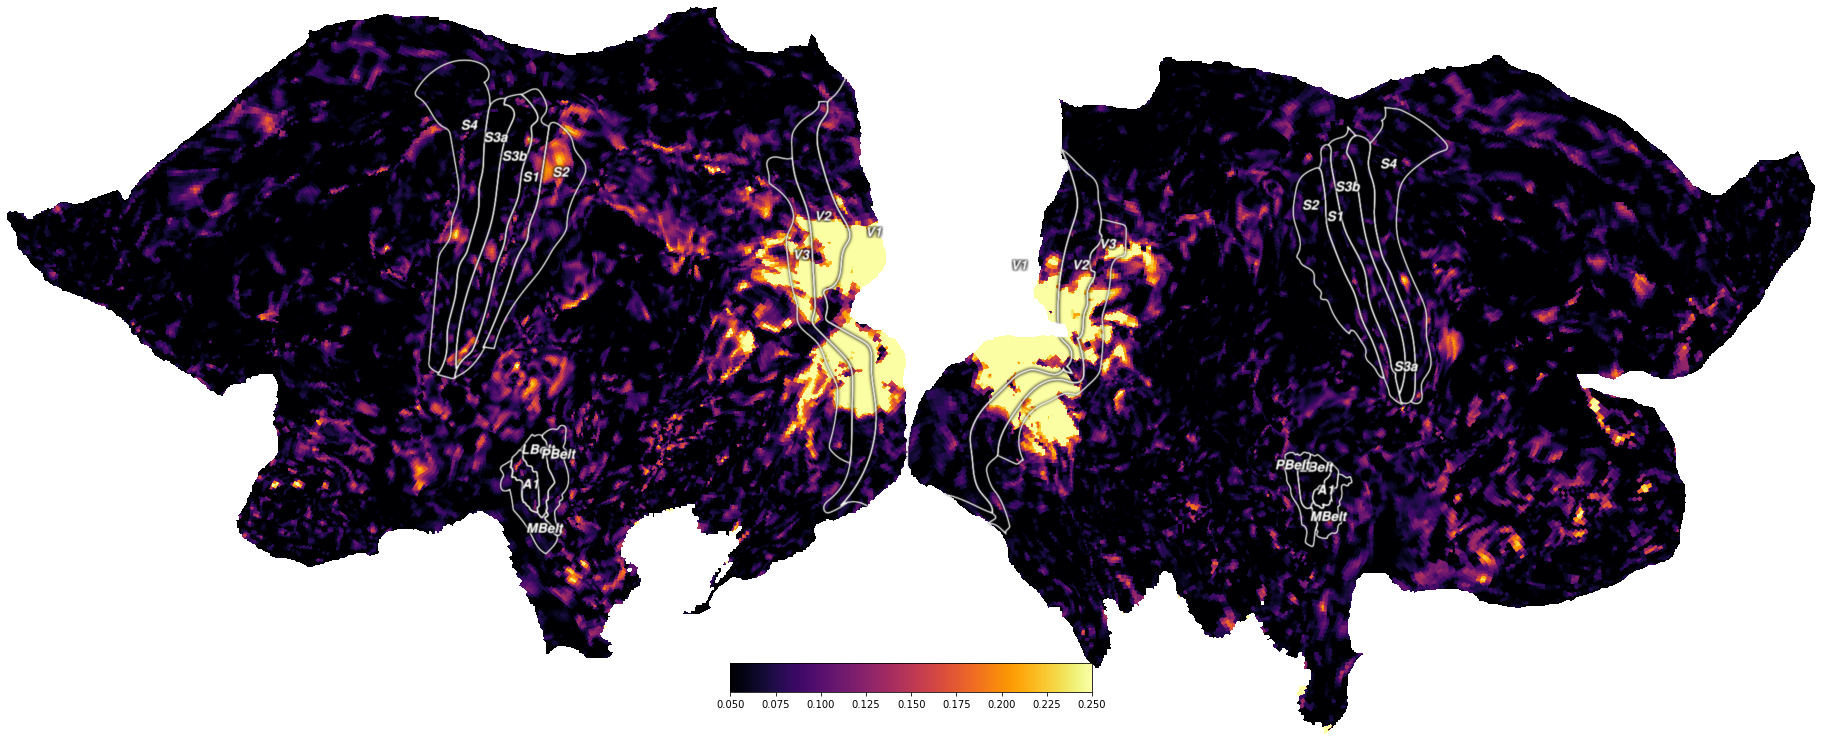

In [ ]:
# the rsq measure tells us where the voxels are whose signal is explained 
# using the FIR model. Not suprisingly, a simple visual stimulus causes
# BOLD responses mainly in low-level visual cortex.

cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0.05, vmax=0.25));

2404 responsive voxels detected in V1 using threshold 0.05


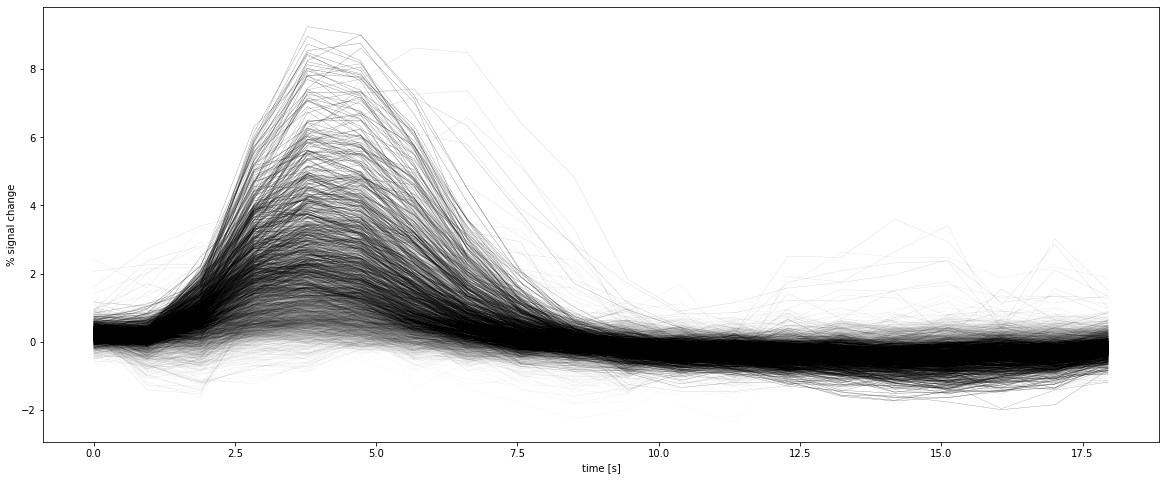

In [ ]:
rsq_threshold = 0.05
rsq_mask = rsq > rsq_threshold
V1_mask = atlas_data_both_hemis == 1

responsive_V1_vertex_rsq = rsq[rsq_mask & V1_mask]
responsive_V1_vertex_FIR_timecourses = betas[1:,rsq_mask & V1_mask]
# how many?
print(f'{responsive_V1_vertex_FIR_timecourses.shape[1]} responsive voxels detected in V1 using threshold {rsq_threshold}')

plt.figure(figsize=(20,8))
for i, tc in enumerate(responsive_V1_vertex_FIR_timecourses.T):
    plt.plot(np.arange(n_timepoints)*tr, tc, c='k', lw=0.25, alpha=responsive_V1_vertex_rsq[i]);
plt.xlabel('time [s]')
plt.ylabel('% signal change');

# Report Outline

This part of the notebook outlines the sections we expect your report to contain. You can use this part as a to-be-filled-in template for your project report. The total text should not be too long, so that you don't needlessly pain your long-suffering colleagues. Say, 2000 words max. 



## Title 

a title is more important than you think - a good title draws the reader in. An excellent title is a bit playful without going over the top. Before you finish the report, spend a few minutes brainstorming on the perfect title. It pays off.

## Abstract

An abstract is a brief (say, around 200 words) summary of the research, methods, as well as the findings and their significance. 

## Introduction

Why this research? What does this specific experiment teach us about the brain? Be sure to discuss the articles that go with your project, and any and all additional articles that you've found. Feel free to add figures from published articles to clarify the approach. 

## Methods 

In the methods section, you should describe the experiment and your analyses in as much detail as possible, or at least to the level of detail required for others to replicate your findings. Clearly you don't have all the information regarding scanning parameters, etc, so we won't fault you for not including those here. 

## Results

It's easiest to base your results section around a few (say, 4 or 5) key figures that illustrate what you've done and what you've found. These can be illustrations, flatmaps, time-courses and/or anything that you decide is a cool visualization of your results. You can start with a description of the data as you're getting it, basing yourself on the *Questions concerning signal quality* etc. above. 

Be sure to describe your figures with adequate captions. For these results, we will focus on qualitative descriptions and not so much on hard stats - which are harder to do on single subjects. 

I hope you will have fun creating this project and I also hope that your findings will reflect the fun you have. 

## Discussion

*   What have we learned? 
*   What should others be aware of? 
*   In what sense do your findings correspond to the literature you know, and in what sense do your findings deviate from the canon? 

What have you learned?

Feel free to add references that you've stumbled upon yourselves. 